In [10]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time, os, csv
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import cv2
from PIL import Image
import torch.nn.functional as F


In [11]:

# -----------------------------
# CONFIG
# -----------------------------
data_dir = "/content/drive/MyDrive/Colab Notebooks/IBM datathon/dataset1"   # expects train/, val/, test/ folders
batch_size = 16
num_epochs = 15
lr = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



Using device: cpu


In [12]:
# -----------------------------
# DATA TRANSFORMS
# -----------------------------
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(0.2,0.2,0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])
}


In [13]:
# -----------------------------
# LOAD DATASETS
# -----------------------------
train_ds = datasets.ImageFolder(os.path.join(data_dir, "train"), data_transforms['train'])
val_ds   = datasets.ImageFolder(os.path.join(data_dir, "val"), data_transforms['val'])
test_ds  = datasets.ImageFolder(os.path.join(data_dir, "test"), data_transforms['test'])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

class_names = train_ds.classes
print("Classes:", class_names)


Classes: ['deforested', 'non-deforested']


In [14]:
# -----------------------------
# MODEL (ResNet50 Fine-tuned)
# -----------------------------
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # freeze backbone

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 2)
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=lr)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
# -----------------------------
# TRAIN FUNCTION (with metrics saving)
# -----------------------------
def train_model(model, criterion, optimizer, num_epochs=10, save_dir="metrics"):
    os.makedirs(save_dir, exist_ok=True)
    best_acc = 0.0
    history = []

    for epoch in range(num_epochs):
        print(f"\n🌀 Epoch {epoch+1}/{num_epochs}")
        for phase, loader in {'train': train_loader, 'val': val_loader}.items():
            model.train() if phase=='train' else model.eval()
            running_loss = 0.0
            running_corrects = 0

            for i, (inputs, labels) in enumerate(loader):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs,1)
                    loss = criterion(outputs, labels)
                    if phase=='train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)

            epoch_loss = running_loss / len(loader.dataset)
            epoch_acc = running_corrects.double() / len(loader.dataset)
            print(f"[{phase.upper()}] Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Save metrics for CSV
            history.append([epoch+1, phase, epoch_loss, epoch_acc.item()])

            # Save best model
            if phase=='val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save({
                    'epoch': epoch+1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'acc': best_acc
                }, "best_logging_detector.pth")
                print(f"✅ Saved new best model (Acc={best_acc:.4f})")

    # Save metrics CSV
    with open(os.path.join(save_dir,"training_history.csv"),"w",newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Epoch","Phase","Loss","Accuracy"])
        writer.writerows(history)

    print(f"\nTraining done. Best val acc = {best_acc:.4f}")
    return model

In [16]:
# -----------------------------
# TRAIN
# -----------------------------
model = train_model(model, criterion, optimizer, num_epochs=num_epochs)

# Load best checkpoint
checkpoint = torch.load("best_logging_detector.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()


🌀 Epoch 1/15
[TRAIN] Loss: 0.4675 Acc: 0.8216
[VAL] Loss: 0.2625 Acc: 0.9513
✅ Saved new best model (Acc=0.9513)

🌀 Epoch 2/15
[TRAIN] Loss: 0.3132 Acc: 0.8824
[VAL] Loss: 0.1668 Acc: 0.9692
✅ Saved new best model (Acc=0.9692)

🌀 Epoch 3/15
[TRAIN] Loss: 0.2511 Acc: 0.9108
[VAL] Loss: 0.1426 Acc: 0.9692

🌀 Epoch 4/15
[TRAIN] Loss: 0.2170 Acc: 0.9167
[VAL] Loss: 0.1260 Acc: 0.9692

🌀 Epoch 5/15
[TRAIN] Loss: 0.2283 Acc: 0.9098
[VAL] Loss: 0.1366 Acc: 0.9615

🌀 Epoch 6/15
[TRAIN] Loss: 0.2020 Acc: 0.9196
[VAL] Loss: 0.1159 Acc: 0.9641

🌀 Epoch 7/15
[TRAIN] Loss: 0.1934 Acc: 0.9294
[VAL] Loss: 0.1041 Acc: 0.9718
✅ Saved new best model (Acc=0.9718)

🌀 Epoch 8/15
[TRAIN] Loss: 0.2154 Acc: 0.9225
[VAL] Loss: 0.1109 Acc: 0.9641

🌀 Epoch 9/15
[TRAIN] Loss: 0.2062 Acc: 0.9294
[VAL] Loss: 0.1145 Acc: 0.9641

🌀 Epoch 10/15
[TRAIN] Loss: 0.1920 Acc: 0.9343
[VAL] Loss: 0.1092 Acc: 0.9641

🌀 Epoch 11/15
[TRAIN] Loss: 0.2036 Acc: 0.9255
[VAL] Loss: 0.1023 Acc: 0.9718

🌀 Epoch 12/15
[TRAIN] Loss: 0.1

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 


📈 Classification Report:
                precision    recall  f1-score   support

    deforested       0.95      1.00      0.97       300
non-deforested       1.00      0.94      0.97       300

      accuracy                           0.97       600
     macro avg       0.97      0.97      0.97       600
  weighted avg       0.97      0.97      0.97       600



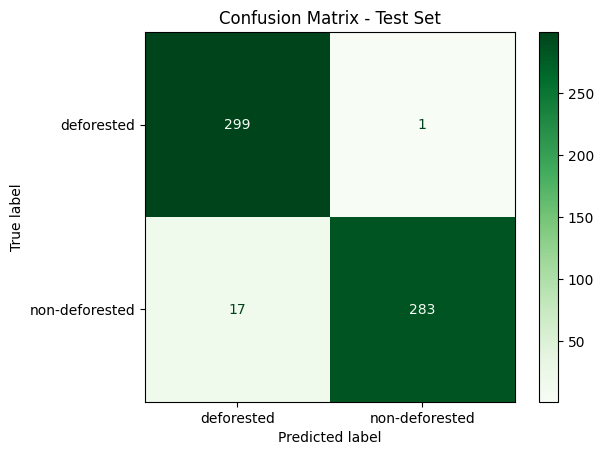

✅ Final model saved as final_logging_detector.pth


In [17]:
# -----------------------------
# EVALUATION & SAVE REPORTS
# -----------------------------
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs,1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
print("\n📈 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Save report as CSV
os.makedirs("reports", exist_ok=True)
with open("reports/classification_report.csv","w",newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Class","Precision","Recall","F1-score","Support"])
    for cls in class_names:
        writer.writerow([cls, report[cls]['precision'], report[cls]['recall'], report[cls]['f1-score'], report[cls]['support']])
    # Also save avg/total
    writer.writerow(["accuracy","","",report["accuracy"],sum([report[c]['support'] for c in class_names])])

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Greens')
plt.title("Confusion Matrix - Test Set")
plt.savefig("reports/confusion_matrix.png")
plt.show()

# Save final model
torch.save(model.state_dict(), "final_logging_detector.pth")
print("✅ Final model saved as final_logging_detector.pth")

# ----